In [61]:
from pathlib import Path
import pandas as pd
from scipy.stats import mannwhitneyu
from sklearn.metrics import auc
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import PandasTools
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [2]:
def extract_mol_params(mol_type):
    mol_type = mol_type.replace('-', '_')
    params = mol_type.split('_')
    if len(params) == 3:
        return tuple(params)
    else:
        return ('', '', '')
        
def collect_results(path, col='minimizedAffinity'):
    output_folders = list(set([f for f in path.glob('*.sdf')])) 
    scores = []
    for file in tqdm(output_folders):
        
        try:
            pdb_id, mol_uniprot_id, mol_type = file.stem.split('_', 2)
        except:
            pdb_id, mol_type = file.stem.split('_', 1)
            mol_uniprot_id = ''
        try:
            docked_df = PandasTools.LoadSDF(str(file), molColName='Molecule')
            if 'Novel' in docked_df.columns.tolist():
                docked_df  = docked_df[docked_df['Novel'] == '1']
            else:
                pass 
            if col == 'minimizedAffinity':
                score = docked_df.groupby('ID')[col].min().reset_index().assign(pdb_id=pdb_id, mol_uniprot_id=mol_uniprot_id, mol_type=mol_type)
            else:
                score = docked_df.groupby('ID')[col].max().reset_index().assign(pdb_id=pdb_id, mol_uniprot_id=mol_uniprot_id, mol_type=mol_type)
            scores.append(score)
        except:
            print(file)
    df_scores = pd.concat(scores).replace({'beam': 'B', 'sampling': 'S', 'random_within': 'randomW'}, regex=True)    
    df_scores['model'], df_scores['dataset'], df_scores['strategy'] = zip(*df_scores['mol_type'].apply(extract_mol_params))
    return df_scores


In [47]:
def calc_rate(lst, threshold, best=None):
    return sum([i <= threshold if best else i > threshold  for i in lst])/len(lst)

def prates(scores1, scores2, best=None):
    return zip(*[(calc_rate(scores1, i, best=best), calc_rate(scores2,i, best=best)) for i in sorted(scores1 + scores2)])

def pr(scores1, scores2, best):
    pairs = []
    for thres in sorted(scores1 + scores2):
        tp = len([i for i in scores1 if i <= thres])
        fp = len([i for i in scores2 if i <= thres])
        pairs.append((tp / (tp + fp), tp / len(scores1))) # precision, recall
    return list(zip(*pairs))

def compute_pairwise_roc(df, col='CNNscore'):
    group_cols = ['pdb_id', 'mol_uniprot_id', 'mol_type', 'model', 'strategy']
    groups = df.groupby(group_cols)
    pairwise_comparison = []
    for key1, subdf1 in groups:
        for key2, subdf2 in groups:
            if key1[0] == key2[0] and '_'.join(key1) != '_'.join(key2):
                try:
                    scores1, scores2 = subdf1[col].values.tolist(), subdf2[col].values.tolist()
                    tpr, fpr = prates(scores1, scores2, best=('min' if col =='minimizedAffinity' else None))
                    pairwise_comparison.append({'p_value': mannwhitneyu(scores1, scores2).pvalue,
                                                'tpr': tpr,
                                                'fpr': fpr,
                                                'auc': auc(fpr, tpr), 
                                                **{col + '1' : val for col, val in zip(group_cols, key1)},
                                                **{col + '2' : val for col, val in zip(group_cols, key2)}})
                except Exception as exc:
                    print(exc)
                    print(key1, key2)

    return pd.DataFrame(pairwise_comparison)

def compute_rocs_vs(df_rocs, pdb_id, other_uniprot_id=None):
    random = df_rocs[(df_rocs['pdb_id2'] == pdb_id) & (df_rocs['mol_type2'] == 'random') & (df_rocs['mol_uniprot_id1'] == pdb_to_uniprot[pdb_id])]
    known = df_rocs[(df_rocs['pdb_id2'] == pdb_id) & (df_rocs['mol_uniprot_id2'] == pdb_to_uniprot[pdb_id]) & (df_rocs['mol_type2'] == 'known') & (df_rocs['mol_uniprot_id1'] == pdb_to_uniprot[pdb_id])]
    if other_uniprot_id: 
        randomw = df_rocs[(df_rocs['pdb_id2'] == pdb_id) & (df_rocs['mol_uniprot_id2'] == pdb_to_uniprot[pdb_id]) & (df_rocs['mol_type2'] == 'randomW') & (df_rocs['mol_uniprot_id1'] == pdb_to_uniprot[pdb_id])]
        other_random = df_rocs[(df_rocs['pdb_id2'] == pdb_id) & (df_rocs['mol_type2'] == 'random') & (df_rocs['mol_uniprot_id1'] == other_uniprot_id)]
        other_known = df_rocs[(df_rocs['pdb_id2'] == pdb_id) & (df_rocs['mol_uniprot_id2'] == pdb_to_uniprot[pdb_id]) & (df_rocs['mol_type2'] == 'known') & (df_rocs['mol_uniprot_id1'] == other_uniprot_id)]
        return {'Random': random, 'Known': known, 'RandomW': randomw, 
                'Generated for Other vs Random': other_random, 
                'Generated for Other vs Known': other_known}
    else:
        return {'Random': random, 'Known': known}
    

In [48]:
def to_str(x):
    x['auc'] = round(x['auc'], 2)
    x['p_value'] = "{:.2e}".format(x['p_value']) if round(x['p_value'], 2) == 0 else str(round(x['p_value'], 2))
    return x

def format_comparisons(df_indexed, pdb_id, other_uniprot_id):
    random = df_indexed.loc[pdb_id].loc[''].loc['random'].loc[pdb_to_uniprot[pdb_id]].apply(to_str, axis=1)
    random['?'] = random['p_value'] <= 0.05
    others = df_indexed.loc[pdb_id].loc[pdb_to_uniprot[pdb_id]].loc['randomW'].loc[pdb_to_uniprot[pdb_id]].apply(to_str, axis=1)
    others['?'] = others['p_value'] <= 0.05
    known = df_indexed.loc[pdb_id].loc[pdb_to_uniprot[pdb_id]].loc['known'].loc[pdb_to_uniprot[pdb_id]].apply(to_str, axis=1)
    known['?'] = known['p_value'] <= 0.05
    other_random = df_indexed.loc[pdb_id].loc[''].loc['random'].loc[other_uniprot_id].apply(to_str, axis=1)
    other_random['?'] = other_random['p_value'] <= 0.05
    other_known =  df_indexed.loc[pdb_id].loc[pdb_to_uniprot[pdb_id]].loc['known'].loc[other_uniprot_id].apply(to_str, axis=1)
    other_known['?'] = other_known['p_value'] <= 0.05
    return pd.concat([random.add_suffix('_random'), 
                      others.add_suffix('_randomW'), 
                      known.add_suffix('_known'),
                      other_random.add_suffix('_other_random'),
                      other_known.add_suffix('_other_known')], axis=1)


In [49]:
def plot_rocs_all(pairs, mol_key, title, ax):
    # fig = plt.figure()
    pairs['p_value_str'] = pairs['p_value'].apply(lambda x: "{:.2e}".format(x) if round(x, 2) == 0 else str(round(x, 2)))
    pairs = pairs.replace({'known': 'Active', 'random': 'Random'})
    pairs = pairs.sort_values(by=mol_key)
    for row in pairs.iterrows():
        label = f"{row[1][mol_key]} ({round(row[1]['auc'], 3)}, p={row[1]['p_value_str']})".expandtabs()

        ax.plot(row[1]['fpr'], row[1]['tpr'], label=label)

    ax.set_title(title)
    # ax.legend(title=f'Molecules for {title}', loc='upper center', bbox_to_anchor=(0.5, -0.2),fancybox=False, shadow=False, ncol=1)
    ax.legend(prop={'size': 10}) # bbox_to_anchor=(1.05, 1))    
    
    #ax.xlabel('False Positive Rate (FPR)')
    #ax.ylabel('True Positive Rate (TPR)')

    

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.35it/s]
C:\Users\gokce\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:02<00:00,  4.54it/s]
C:\Users\gokce\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

<Figure size 432x288 with 0 Axes>

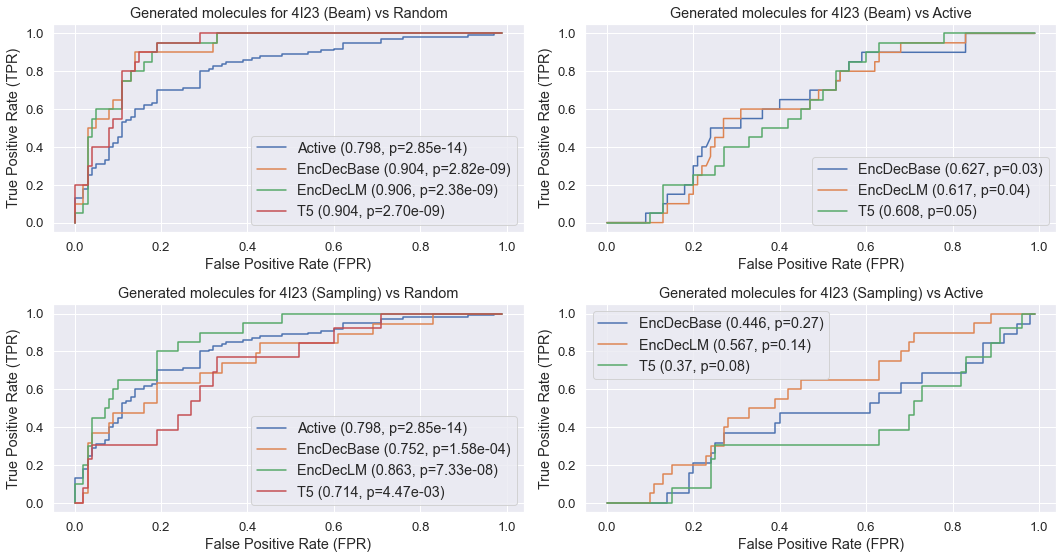

<Figure size 432x288 with 0 Axes>

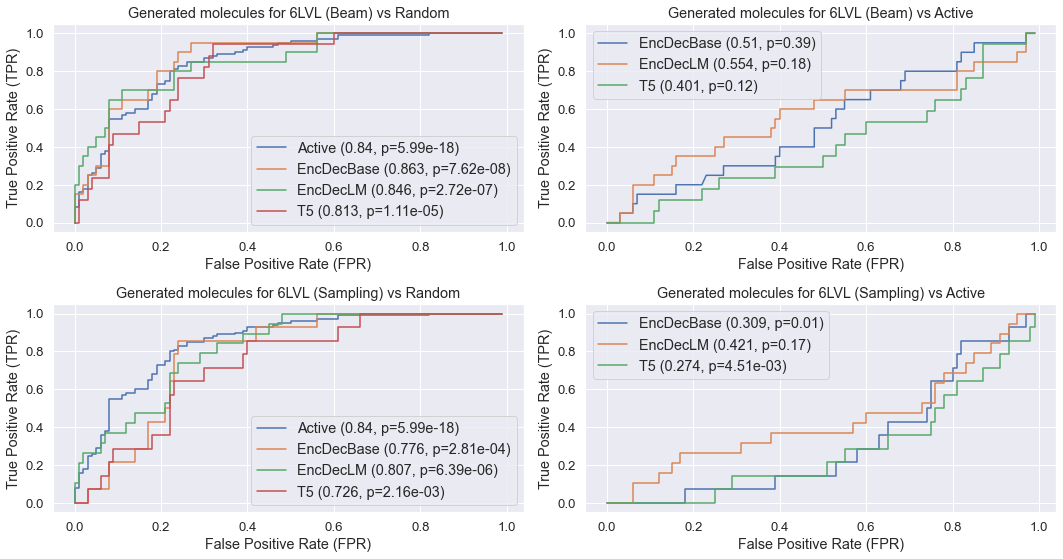

<Figure size 432x288 with 0 Axes>

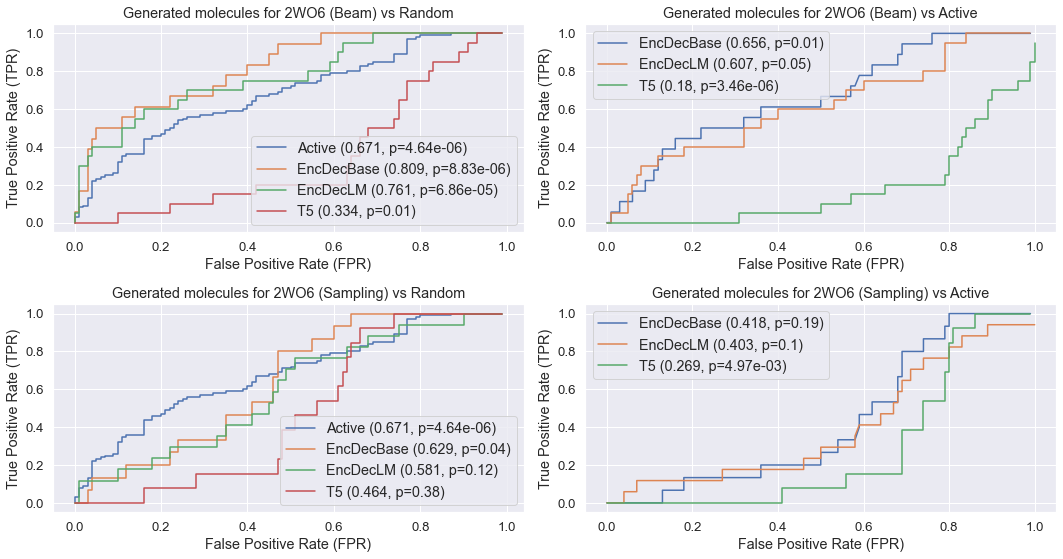

<Figure size 432x288 with 0 Axes>

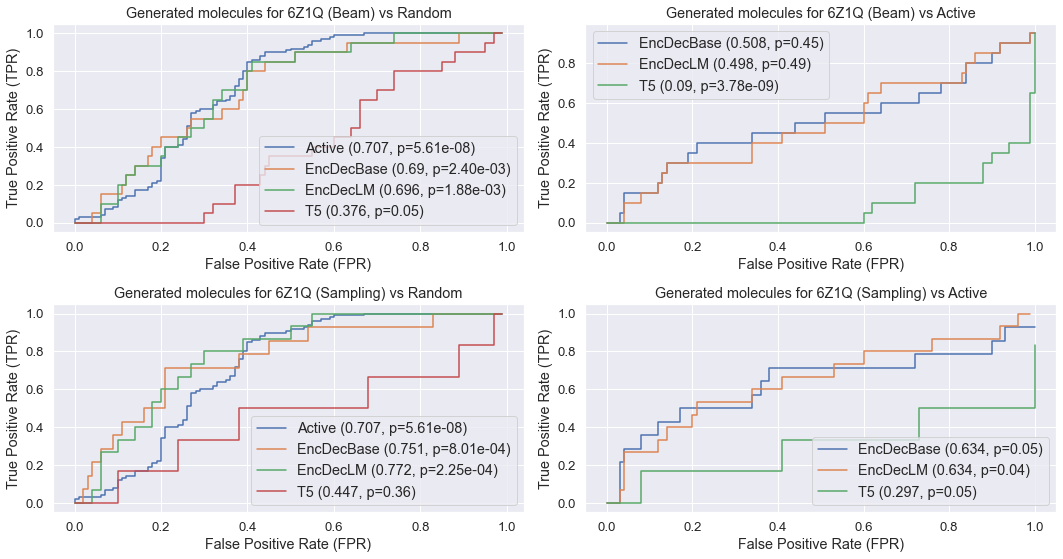

<Figure size 432x288 with 0 Axes>

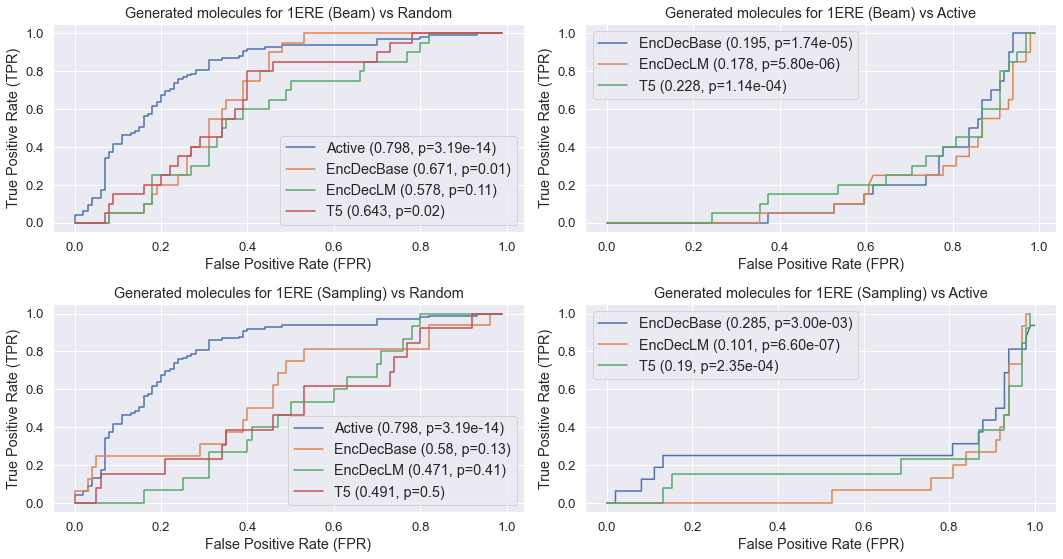

<Figure size 432x288 with 0 Axes>

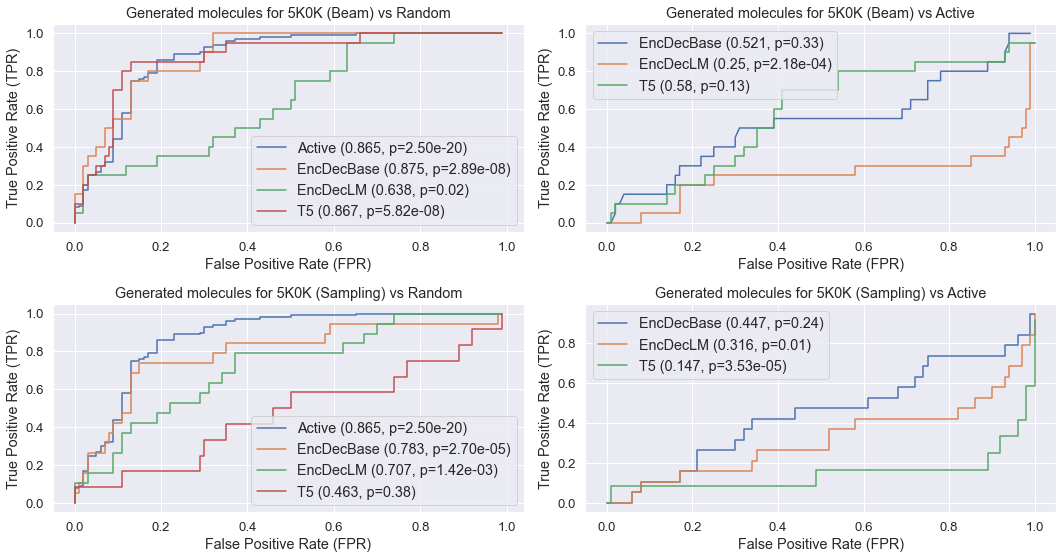

<Figure size 432x288 with 0 Axes>

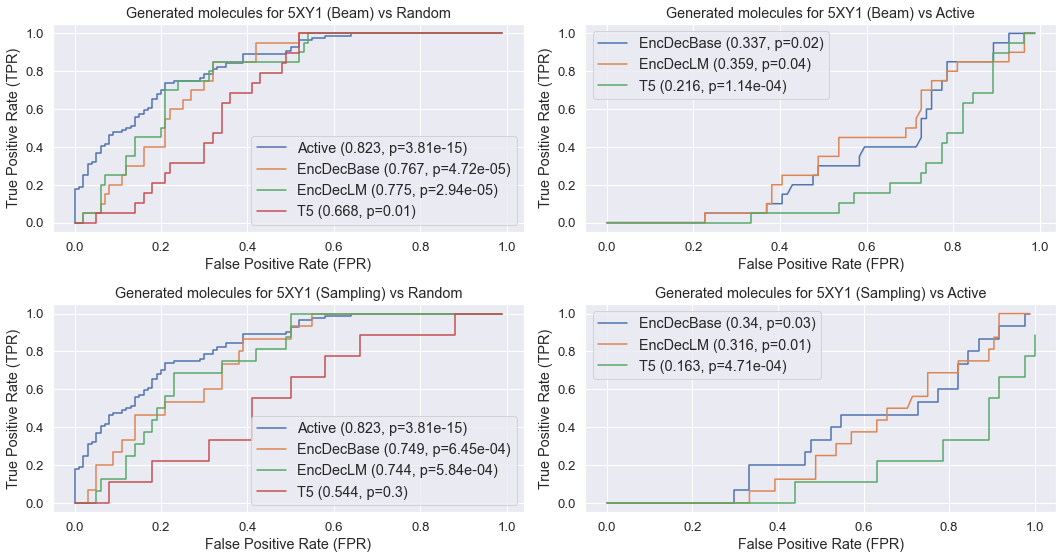

<Figure size 432x288 with 0 Axes>

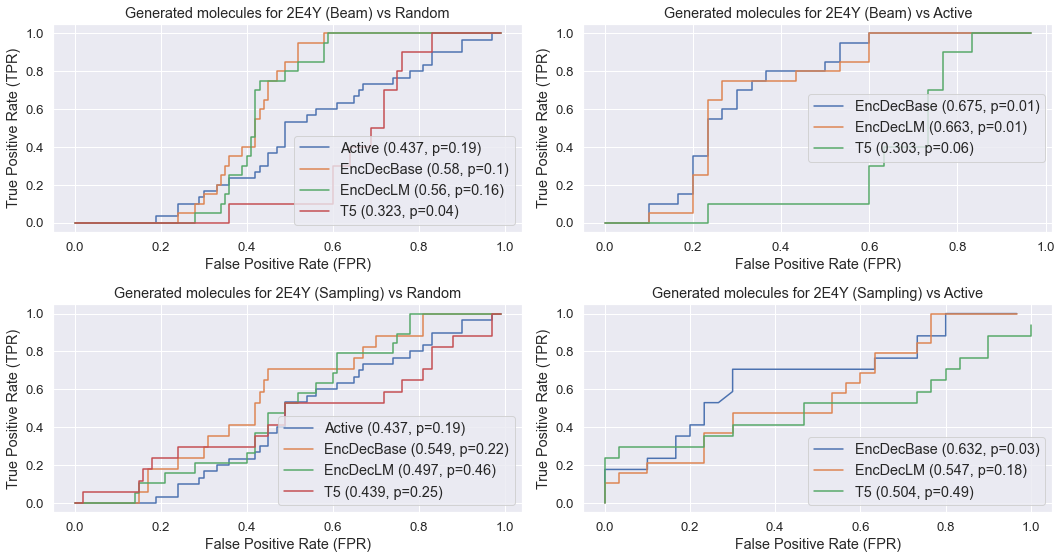

<Figure size 432x288 with 0 Axes>

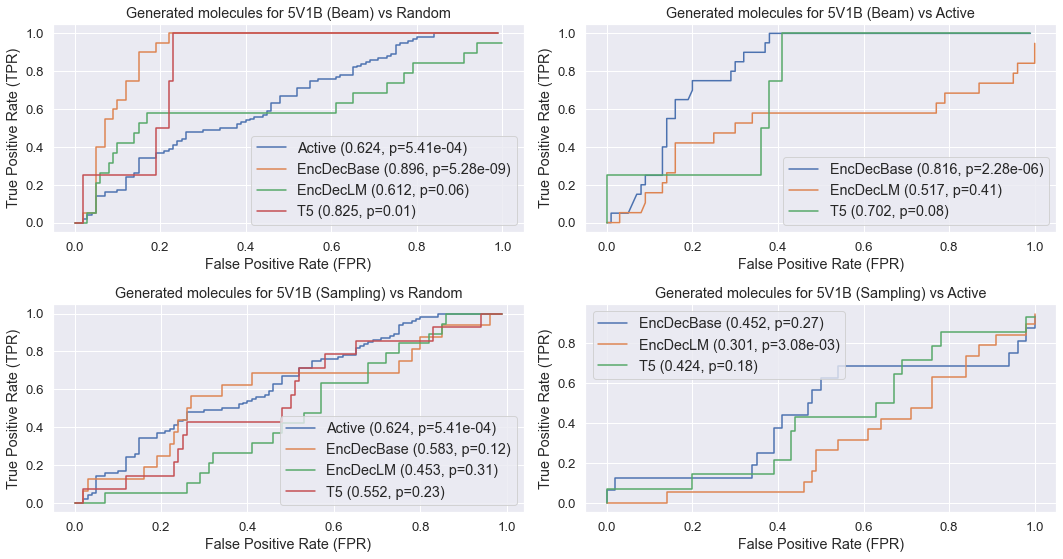

<Figure size 432x288 with 0 Axes>

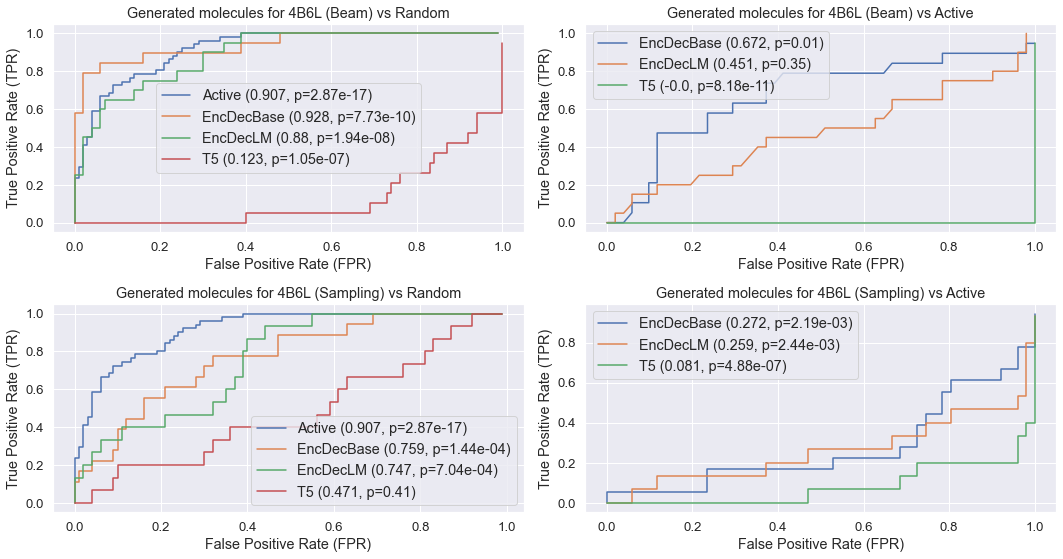

<Figure size 432x288 with 0 Axes>

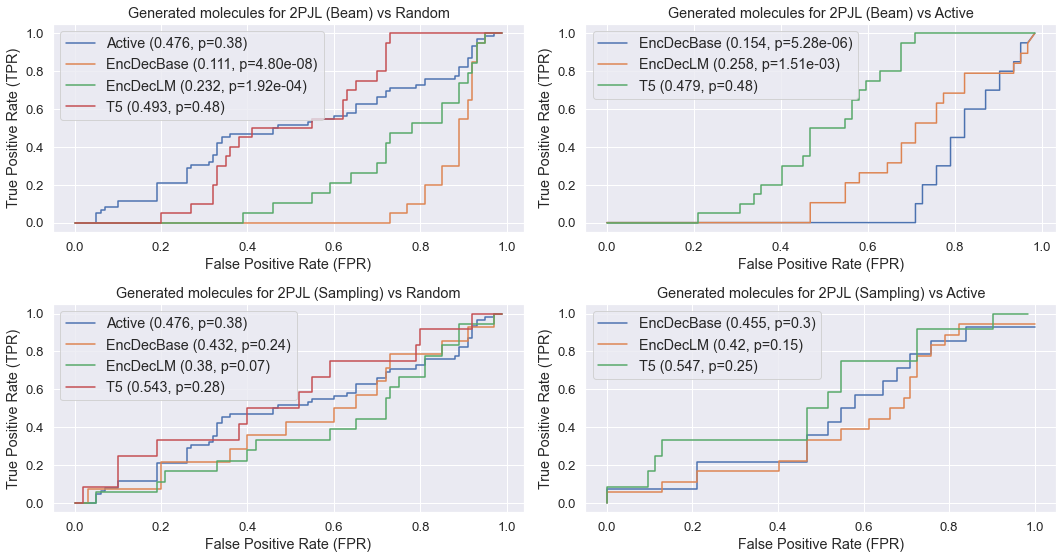

<Figure size 432x288 with 0 Axes>

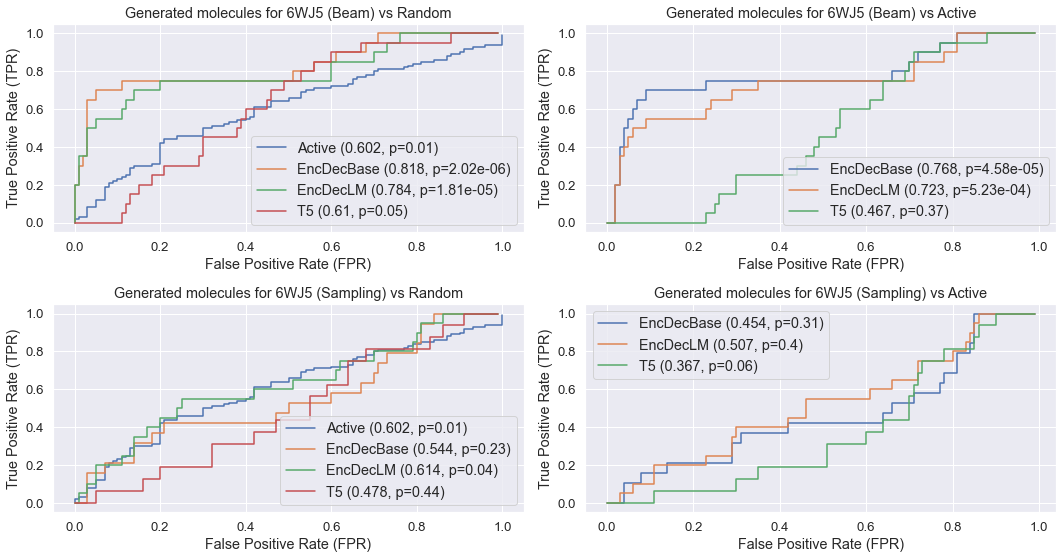

<Figure size 432x288 with 0 Axes>

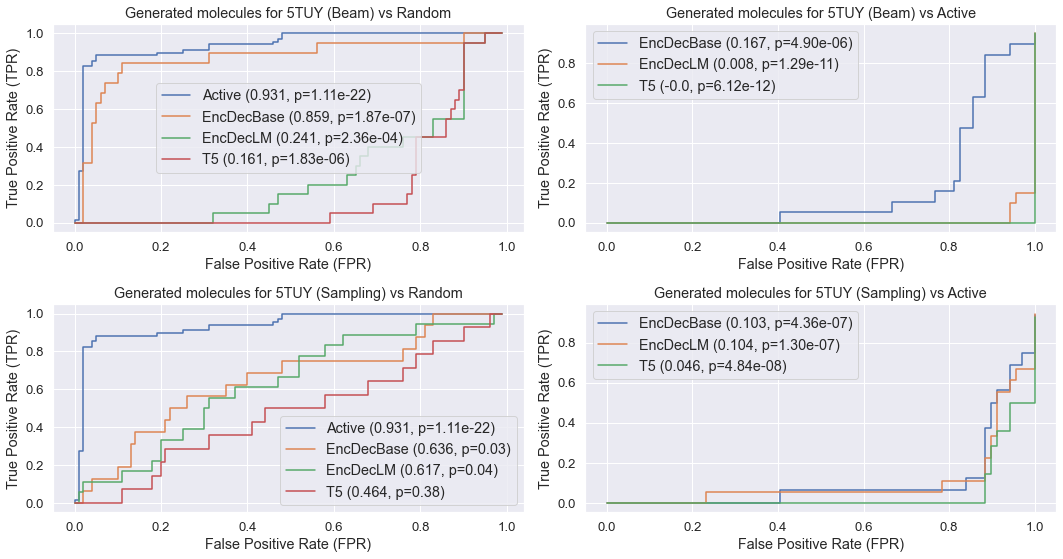

In [50]:
# ECCCB V2
path = Path('../docking/complex/')
sns.set_context("paper")
sns.set(font_scale = 1.2)
comparisons = []
cold_rocs = []
known_vs_random = []
pdb_to_uniprot = {}
cold_proteins = [('P00533', '4I23'), ('P21802', '6LVL'), ('Q9Y463', '2WO6'), ('Q99558', '6Z1Q'),
                ('P03372', '1ERE'), ('Q12866', '5K0K'), ('P07948', '5XY1'), 
                ('P31422', '2E4Y'), #known binders cannot be discriminated from random molecules
                ('Q96KS0', '5V1B'),  ('Q9H4B4', '4B6L'), 
                ('P11474', '2PJL'), #: known binders cannot be discriminated from random molecules
                ('O75762', '6WJ5'), ('Q96KQ7', '5TUY')

                ]

pdb_to_uniprot.update(dict([(pdb, uniprot) for uniprot, pdb in cold_proteins]))
for target, pdb_id in cold_proteins:
    cold_scores = collect_results(path / target, col='CNNaffinity')
    cold_scores = cold_scores[cold_scores['mol_type'] != 'EncDecBase_100%_B_others']
    cold_scores['mol_type'] = cold_scores['mol_type'].apply(lambda x: x.replace('_100%_B', '').replace('_100%_S', ''))
 
    pairwise_roc_cold = compute_pairwise_roc(cold_scores, col='CNNaffinity')
    pairwise_roc_cold['p_value_str'] = pairwise_roc_cold['p_value'].apply(lambda x: "{:.2e}".format(x) if round(x, 3)  == 0 else str(round(x, 3)))
    pairwise_roc_cold['comparison'] = pairwise_roc_cold['mol_type1'] + ' vs ' + pairwise_roc_cold['mol_type2']
    pairwise_roc_cold.set_index('comparison', inplace=True)
    cold_rocs.append(pairwise_roc_cold)
    comparisons.append(pairwise_roc_cold[(pairwise_roc_cold['mol_type1'] == 'known') | (pairwise_roc_cold['mol_type2'] == 'random') ][['p_value_str']].T.assign(pdb_code=pdb_id))
    
    pairwise_roc_cold_filtered = pairwise_roc_cold[(pairwise_roc_cold['mol_type1'] != 'others')  & (pairwise_roc_cold['mol_type2'] != 'others')]
    
    rocs_target = compute_rocs_vs(pairwise_roc_cold_filtered, pdb_id)
    plt.figure()
    fig, axes = plt.subplots(2, 2, figsize=(15, 8))
    # fig.subplots_adjust(bottom=0.3, wspace=0.33)

    # plt.plot(x,y)
    rocs_target['Active'] = rocs_target.pop('Known')

    for ix, (molecules, scores) in enumerate(rocs_target.items()):
        scores_beam = scores[scores['strategy1'] != 'S']
        plot_rocs_all(scores_beam, 'mol_type1', f'Generated molecules for {pdb_id} (Beam) vs {molecules}', axes[0][ix])
        scores_sampling = scores[scores['strategy1'] != 'B']
        plot_rocs_all(scores_sampling, 'mol_type1', f'Generated molecules for {pdb_id} (Sampling) vs {molecules}', axes[1][ix])
    for ax in axes.flat:
        ax.set(xlabel='False Positive Rate (FPR)', ylabel='True Positive Rate (TPR)')
        ax.legend(fontsize='medium', title_fontsize='40')

    plt.tight_layout()

    plt.savefig(f'../figures/docking/{pdb_id}.pdf', format="pdf", bbox_inches="tight")

    known_vs_random.append(pairwise_roc_cold[(pairwise_roc_cold['mol_type1'] == 'known') & (pairwise_roc_cold['mol_type2'] == 'random')].assign(pdb_code=pdb_id))
    
df_comparisons = pd.concat(comparisons)   
df_colds = pd.concat(cold_rocs)
df_k_r = pd.concat(known_vs_random)

In [52]:
df_colds['p_value_str'] = df_colds['p_value'].apply(lambda x: "{:.2e}".format(x) if round(x, 3) == 0 else str(round(x, 3)))
df_colds['auc_str'] = df_colds['auc'].apply(lambda x: str(round(x, 2)))

In [53]:
known_rand = df_colds[(df_colds['mol_type1'] == 'known') &  (df_colds['mol_type2'] == 'random')].assign(vs='Known vs Generated')
gen_vs_rand = df_colds[(df_colds['mol_type1'] == 'EncDecBase_100%_B') & (df_colds['mol_type2'] == 'random')].assign(vs='Generated vs Random')
others_vs_rand = df_colds[(df_colds['mol_type1'] == 'EncDecBase_100%_B_others') & (df_colds['mol_type2'] == 'random')].assign(vs='GenOthers vs Random')
known_gen = df_colds[(df_colds['mol_type1'] == 'known') &  (df_colds['mol_type2'] == 'EncDecBase_100%_B')].assign(vs='Known vs Generated')

known_others = df_colds[(df_colds['mol_type1'] == 'known') &  (df_colds['mol_type2'] == 'EncDecBase_100%_B_others')].assign(vs='Known vs GenOthers')
gen_others = df_colds[(df_colds['mol_type1'] == 'EncDecBase_100%_B') &  (df_colds['mol_type2'] == 'EncDecBase_100%_B_others')].assign(vs='Generated vs GenOthers')
best_model_comparison = pd.concat([known_rand.set_index('pdb_id1')[['p_value_str', 'auc_str']].add_suffix('_known_vs_random'),
           gen_vs_rand.set_index('pdb_id1')[['p_value_str', 'auc_str']].add_suffix('_generated_vs_random'),
           others_vs_rand.set_index('pdb_id1')[['p_value_str', 'auc_str']].add_suffix('_others_vs_random'),
           known_gen.set_index('pdb_id1')[['p_value_str', 'auc_str']].add_suffix('_known_vs_generated'),
           known_others.set_index('pdb_id1')[['p_value_str', 'auc_str']].add_suffix('_known_vs_others'),
           gen_others.set_index('pdb_id1')[['p_value_str', 'auc_str']].add_suffix('_generated_vs_others')], axis=1)

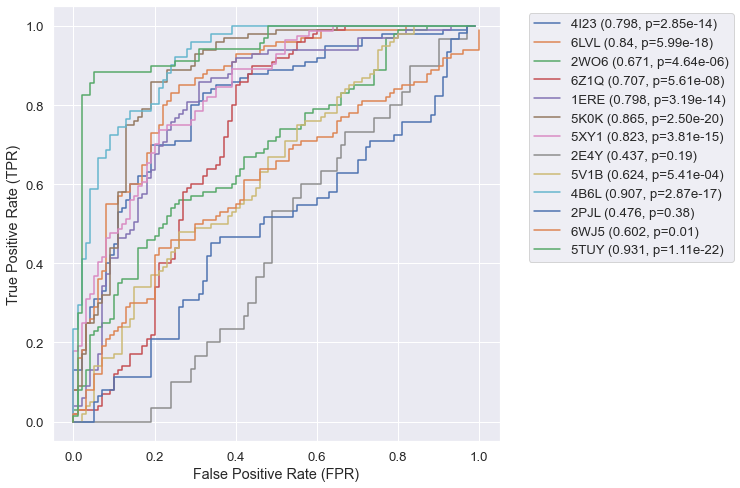

In [18]:
df_k_r['p_value_str'] = df_k_r['p_value'].apply(lambda x: "{:.2e}".format(x) if round(x, 2) == 0 else str(round(x, 2)))

fig = plt.figure(figsize=(8, 8))
for row in df_k_r.iterrows():
    label = f"{row[1]['pdb_code']} ({round(row[1]['auc'], 3)}, p={row[1]['p_value_str']})".expandtabs()
    plt.plot(row[1]['fpr'], row[1]['tpr'], label=label)

plt.legend(bbox_to_anchor=(1.05, 1))    
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.savefig('../figures/docking_discrimination.pdf', format="pdf", bbox_inches="tight")

In [59]:
def format_comparisons(df_indexed, pdb_id):
    random = df_indexed.loc[pdb_id].loc[''].loc['random'].apply(to_str, axis=1)
    others = df_indexed.loc[pdb_id].loc[pdb_to_uniprot[pdb_id]].loc['others'].apply(to_str, axis=1)
    known = df_indexed.loc[pdb_id].loc[pdb_to_uniprot[pdb_id]].loc['known'].apply(to_str, axis=1)
    return pd.concat([random.add_suffix('_random'), others.add_suffix('_others'), known.add_suffix('_known')], axis=1)
    
df_pivot = pd.pivot_table(df_colds, index=['pdb_id2', 'mol_uniprot_id2', 'mol_type2', "strategy1", "model1", "mol_type1"])
cold_comparison_tables = {uniprot: format_comparisons(df_pivot, pdb) for uniprot, pdb in cold_proteins}

In [70]:
import packaging.version
import pandas
import pandas.io.formats.excel

def get_format_module():
    version = packaging.version.parse(pandas.__version__)
    if version < packaging.version.parse('0.18'):
        return pandas.core.format
    elif version < packaging.version.parse('0.20'):
        return pandas.formats.format
    else:
        return pandas.io.formats.excel.ExcelFormatter
get_format_module()
pd.io.formats.header_style = None


In [79]:
def significance_vs_known(x): 
    if x['p_value_known'] >= 0.05:
        return 'Same'
    if x['auc_known'] > 0.5:
        return 'Positive'
    return 'Negative'

def significance_vs_random(x): 
    if x['p_value_random'] >= 0.05:
        return 'Same'
    if x['auc_random'] > 0.5:
        return 'Positive'
    return 'Negative'

sig_diff_random = []
significance_tables = []
for uid, table in cold_comparison_tables.items():
    table['sign_vs_random'] = ((table['p_value_random'] <= 0.05) & (table['auc_random'] >= 0.5))
    table['sign_vs_random2'] = table.apply(significance_vs_random, axis=1)

    table['sign_vs_others'] = ((table['p_value_others'] <= 0.05) & (table['auc_others'] >= 0.5))
    table['sign_known'] = table.apply(significance_vs_known, axis=1)
    significance_tables.append(table.assign(target=uid))
    sig_diff_random.append(table[((table['p_value_random'] <= 0.05) & (table['auc_random'] >= 0.5)) & ((table['p_value_others'] <= 0.05) & (table['auc_others'] >= 0.5))].assign(target=uid))
    
significant_random = pd.concat(sig_diff_random).reset_index()
significant_random = significant_random[significant_random['mol_type1'] != 'known']
df_significance_tables = pd.concat(significance_tables).reset_index()
df_significance_tables = df_significance_tables[df_significance_tables['strategy1'] != '']

In [80]:
print(df_significance_tables.to_string())

    strategy1      model1   mol_type1  auc_random  p_value_random  auc_others  p_value_others  auc_known  p_value_known  sign_vs_random sign_vs_random2  sign_vs_others sign_known  target
3           B  EncDecBase  EncDecBase        0.90    2.820000e-09        0.85    3.790000e-07       0.63   3.000000e-02            True        Positive            True   Positive  P00533
4           B    EncDecLM    EncDecLM        0.91    2.380000e-09        0.85    3.320000e-07       0.62   4.000000e-02            True        Positive            True   Positive  P00533
5           B          T5          T5        0.90    2.700000e-09        0.85    3.550000e-07       0.61   5.000000e-02            True        Positive            True       Same  P00533
6           S  EncDecBase  EncDecBase        0.75    1.580000e-04        0.71    1.340000e-03       0.45   2.700000e-01            True        Positive            True       Same  P00533
7           S    EncDecLM    EncDecLM        0.86    7.330000e-08

In [84]:
print(df_significance_tables[df_significance_tables['sign_vs_random']].groupby(['strategy1', 'model1'])['mol_type1'].count().reset_index().to_string())

  strategy1      model1  mol_type1
0         B  EncDecBase         11
1         B    EncDecLM          8
2         B          T5          7
3         S  EncDecBase          8
4         S    EncDecLM          8
5         S          T5          2


In [92]:
print(df_significance_tables[(df_significance_tables['sign_vs_random']) 
                      & (df_significance_tables['sign_known'] != 'Negative')].groupby(['strategy1', 'model1'])['mol_type1'].count().reset_index().to_string())

  strategy1      model1  mol_type1
0         B  EncDecBase          8
1         B    EncDecLM          6
2         B          T5          5
3         S  EncDecBase          4
4         S    EncDecLM          4
5         S          T5          1
